<a href="https://colab.research.google.com/github/tanvir-152/Thesis_Codes/blob/main/minigcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive "

/content/drive/MyDrive 


In [ ]:
#pip install --upgrade pip

In [ ]:
#!pip install tensorflow==2.11

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio
import scipy.io as sio
import tensorflow.compat.v1 as v1
from tensorflow.keras.layers.experimental import preprocessing
from tf_utils import random_mini_batches_GCN

In [ ]:
from tf_utils import random_mini_batches_single, convert_to_one_hot
from tensorflow.python.framework import ops

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
def create_placeholders(n_x, n_y):

    isTraining = v1.placeholder_with_default(True, shape=())
    x_in = v1.placeholder(tf.float32,  [None, n_x], name = "x_in")
    y_in = v1.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap_train = v1.placeholder(tf.float32, [None, None], name = "lap_train")

    return x_in, y_in, lap_train, isTraining

In [ ]:
def initialize_parameters():

    v1.set_random_seed(1)

    x_w1 = v1.get_variable("x_w1", [200,128], initializer = tf.initializers.GlorotUniform (seed = 1))
    x_b1 = v1.get_variable("x_b1", [128], initializer = v1.zeros_initializer())

    x_w2 = v1.get_variable("x_w2", [128,16], initializer = tf.initializers.GlorotUniform (seed = 1))
    x_b2 = v1.get_variable("x_b2", [16], initializer = v1.zeros_initializer())


    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}

    return parameters

In [ ]:
def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)

    return x_out

In [ ]:
def mynetwork(x, parameters, Lap, isTraining, momentums = 0.9):

    with tf.name_scope("x_layer_1"):

         x_z1_bn = v1.layers.batch_normalization(x, momentum = momentums, training = isTraining)
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)

    with tf.name_scope("x_layer_3"):

         x_z2_bn = v1.layers.batch_normalization(x_a1, momentum = momentums, training = isTraining)
         x_z2 = GCN_layer(x_z2_bn, Lap, parameters['x_w2']) + parameters['x_b2']

    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])

    return x_z2, l2_loss

In [ ]:
print(tf. __version__)

2.12.0


In [ ]:
def mynetwork_optimaization(y_est, y_re, l2_loss, reg, learning_rate, global_step):

    y_re = tf.squeeze(y_re, name = 'y_re')

    with tf.name_scope("cost"):
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = y_re)) +  reg * l2_loss

    with tf.name_scope("optimization"):
         update_ops = v1.get_collection(v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = v1.group([optimizer, update_ops])

    return cost, optimizer

In [ ]:
def network_accuracy(x_out, y_in):

    correct_prediction = tf.equal(tf.argmax(x_out, 1), tf.argmax(y_in, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    return accuracy

In [ ]:
def confusion_mat(x_out, y_in):
  x_cls = tf.transpose(x_out)
  y_cls = tf.transpose(y_in)
  x_cls = tf.argmax(x_out, 1)
  # x_cls = tf.nn.embedding_lookup(np.identity(16), x_cls_)
  # x_cls = convert_to_one_hot(np.array(x_cls)-1, 16)
# TrLabel = TrLabel.T
  y_cls = tf.argmax(y_in, 1)
  confusion = v1.confusion_matrix(y_cls, x_cls, 16)
  return x_cls, y_cls, confusion

In [ ]:
def train_mynetwork(x_train, x_test, y_train, y_test, L_train, L_test, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()
    v1.set_random_seed(1)
    seed = 1
    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape

    costs = []
    costs_dev = []
    train_acc = []
    val_acc = []

    x_in, y_in, lap_train, isTraining = create_placeholders(n_x, n_y)

    parameters = initialize_parameters()

    with tf.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, parameters, lap_train, isTraining)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = v1.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)

    with tf.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         accuracy = network_accuracy(x_out, y_in)

    with tf.name_scope("con"):
         x_cls, y_cls, confusion = confusion_mat(x_out,y_in)

    init = v1.global_variables_initializer()

    with v1.Session() as sess:

        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs + 1):
            epoch_cost = 0.
            epoch_acc = 0.

            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1

            minibatches = random_mini_batches_GCN(x_train, y_train, L_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_y, batch_l) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x_in: batch_x, y_in: batch_y, lap_train: batch_l, isTraining: True})
                epoch_cost += minibatch_cost
                epoch_acc += minibatch_acc

            epoch_cost_train = epoch_cost / (num_minibatches+ 1)
            epoch_acc_train = epoch_acc / (num_minibatches+ 1)


            if print_cost == True and epoch % 50 == 0:
                features, epoch_cost_test, epoch_acc_test = sess.run([x_out, cost, accuracy], feed_dict={x_in: x_test, y_in: y_test, lap_train: L_test, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost_train, epoch_cost_test, epoch_acc_train, epoch_acc_test))

            if print_cost == True and epoch == 200:
                 # con_mat =
                 x, y, confusion = sess.run([x_cls, y_cls, confusion], feed_dict={x_in: x_test, y_in: y_test, lap_train: L_test, isTraining: False})
            #     # print(x.shape)
            #     # print(y.shape)
            #     # print(confusion)

            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost_train)
                train_acc.append(epoch_acc_train)
                costs_dev.append(epoch_cost_test)
                val_acc.append(epoch_acc_test)



        # plot the cost
        # plot the cost
        plt.plot(np.squeeze(costs),label='training loss')
        plt.plot(np.squeeze(costs_dev),label='testing loss')
        plt.ylabel('loss')
        plt.xlabel('epochs (per five)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.legend()
        plt.show()
        # plot the accuracy
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()


        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")



        # return parameters, val_acc, features, confusion, x, y
        return parameters, val_acc, features, x, y, confusion

In [ ]:
Train_X = scio.loadmat("/content/drive/MyDrive/HSI_GCN/Train_X.mat")
TrLabel = scio.loadmat("/content/drive/MyDrive/HSI_GCN/TrLabel.mat")
Test_X = scio.loadmat("/content/drive/MyDrive/HSI_GCN/Test_X.mat")
TeLabel = scio.loadmat("/content/drive/MyDrive/HSI_GCN/TeLabel.mat")
Train_L = scio.loadmat("/content/drive/MyDrive/HSI_GCN/Train_L.mat")
Test_L = scio.loadmat("/content/drive/MyDrive/HSI_GCN/Test_L.mat")
Train_X = Train_X['Train_X']
Test_X = Test_X['Test_X']
TrLabel = TrLabel['TrLabel']
TeLabel = TeLabel['TeLabel']

Train_L = Train_L['Train_L']
Test_L = Test_L['Test_L']

TrLabel = convert_to_one_hot(TrLabel-1, 16)
TeLabel = convert_to_one_hot(TeLabel-1, 16)
TrLabel = TrLabel.T
TeLabel = TeLabel.T
v1.disable_eager_execution()

<ipython-input-167-51db1d8bd04d>:5: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = v1.layers.batch_normalization(x, momentum = momentums, training = isTraining)
<ipython-input-167-51db1d8bd04d>:7: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
<ipython-input-167-51db1d8bd04d>:12: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future v

epoch 0: Train_loss: 2.144906, Val_loss: 1.724226, Train_acc: 0.306095, Val_acc: 0.376797
epoch 50: Train_loss: 0.492354, Val_loss: 1.269098, Train_acc: 0.873909, Val_acc: 0.743667
epoch 100: Train_loss: 0.329774, Val_loss: 1.485525, Train_acc: 0.933277, Val_acc: 0.739220
epoch 150: Train_loss: 0.257970, Val_loss: 1.411103, Train_acc: 0.957313, Val_acc: 0.761038
epoch 200: Train_loss: 0.227364, Val_loss: 1.473402, Train_acc: 0.966097, Val_acc: 0.748113


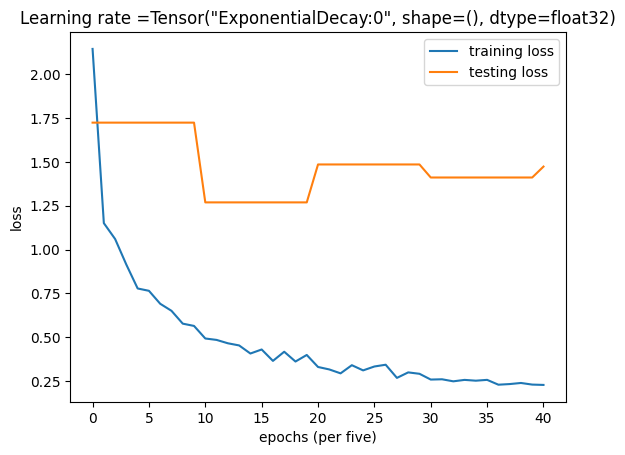

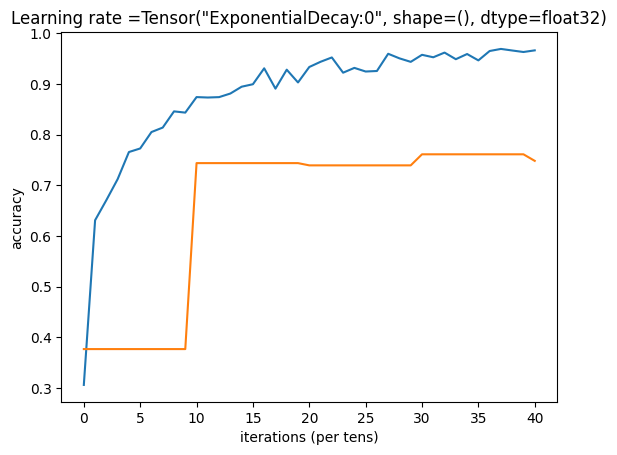

Parameters have been trained!


In [ ]:
parameters, val_acc, features, x, y, confusion = train_mynetwork(Train_X, Test_X, TrLabel, TeLabel, Train_L, Test_L)
sio.savemat('features.mat', {'features': features})

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

<Axes: >

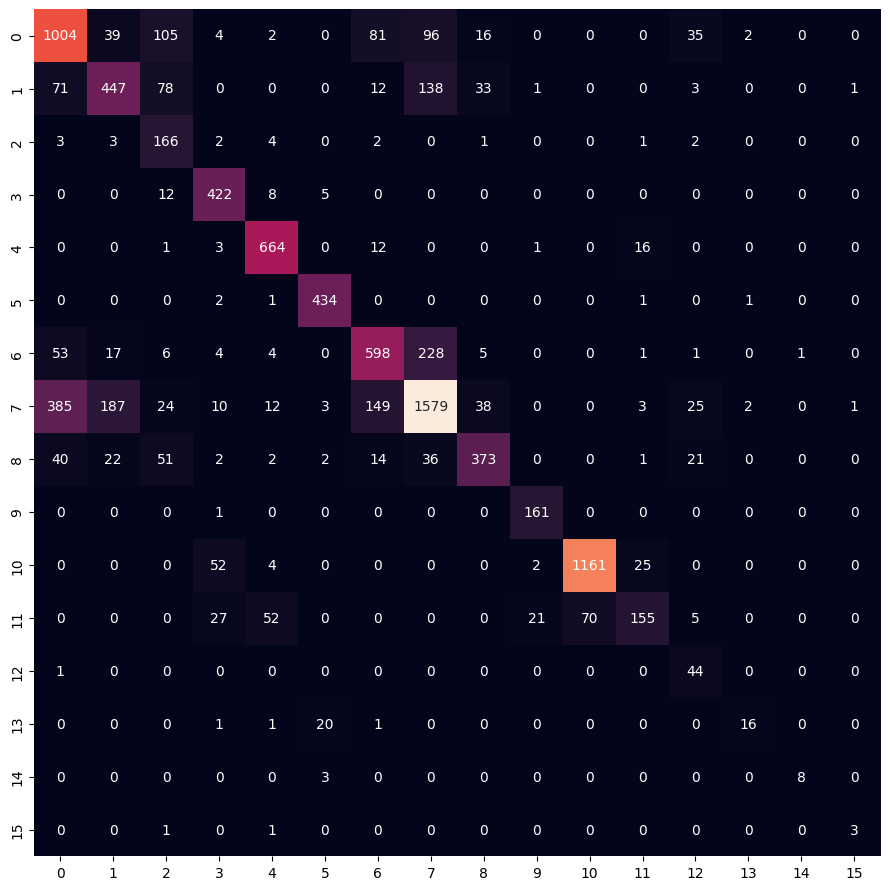

In [ ]:
plt.figure(figsize = (11,11))
sn.heatmap(confusion, square=True, annot=True, fmt='d', cbar=False)

In [ ]:
print(confusion)

[[1004   39  105    4    2    0   81   96   16    0    0    0   35    2
     0    0]
 [  71  447   78    0    0    0   12  138   33    1    0    0    3    0
     0    1]
 [   3    3  166    2    4    0    2    0    1    0    0    1    2    0
     0    0]
 [   0    0   12  422    8    5    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    1    3  664    0   12    0    0    1    0   16    0    0
     0    0]
 [   0    0    0    2    1  434    0    0    0    0    0    1    0    1
     0    0]
 [  53   17    6    4    4    0  598  228    5    0    0    1    1    0
     1    0]
 [ 385  187   24   10   12    3  149 1579   38    0    0    3   25    2
     0    1]
 [  40   22   51    2    2    2   14   36  373    0    0    1   21    0
     0    0]
 [   0    0    0    1    0    0    0    0    0  161    0    0    0    0
     0    0]
 [   0    0    0   52    4    0    0    0    0    2 1161   25    0    0
     0    0]
 [   0    0    0   27   52    0    0    0    0   21   70  155    

In [ ]:
import numpy as np

# Assuming 'confusion_matrix' is the confusion matrix obtained from your model
# It should be a 2D square matrix where confusion_matrix[i, j] represents the count of samples from class i predicted as class j.
# The diagonal of the matrix contains the true positive counts for each class.

correct_predictions = np.trace(confusion)
print(correct_predictions)


7235


In [ ]:
import numpy as np

# Assuming 'confusion_matrix' is a 2D NumPy array representing the confusion matrix

# Calculate the total number of samples for each true class (sum along the rows)
total_samples_per_class = np.sum(confusion, axis=1)

# Calculate the diagonal elements of the confusion matrix (correct predictions per class)
correct_predictions_per_class = np.diagonal(confusion)

# Calculate the probability of correct predictions for each class
probability_per_class = correct_predictions_per_class / total_samples_per_class

# probability_per_class now contains the probability of correct predictions for each class
print(probability_per_class)


[0.72543353 0.57015306 0.90217391 0.94407159 0.95265423 0.98861048
 0.65141612 0.65301902 0.66134752 0.99382716 0.93327974 0.46969697
 0.97777778 0.41025641 0.72727273 0.6       ]


In [ ]:
print(len(features))
features_gcn = features
print(len(features_gcn))

9671
9671
